In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import datetime
import time
plt.style.use('default')
from alpha_vantage.timeseries import TimeSeries

In [3]:
day_open = 60 * 60 * 9.5
seconds = int((60 * 60 * 6.5))
# times = [str(datetime.timedelta(seconds=(i+day_open) % (12 * 3600))) for i in range(seconds + 1) 
#              if i % 1800 == 0]
times = [time.strftime('%I:%M', time.gmtime(i + day_open)) for i in range(seconds + 1) 
             if i % 1800 == 0]
time_ids = [i for i in range(seconds + 1) if i % 1800 == 0]
expected = (seconds + 1) ** 0.5

In [4]:
60 * 2

120

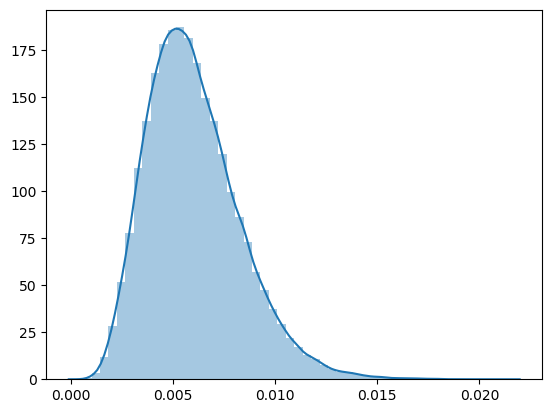

In [5]:
expected_volatility = 0.006
shape = 7
sns.distplot(np.random.gamma(shape=shape, scale=expected_volatility / shape, size=100000))

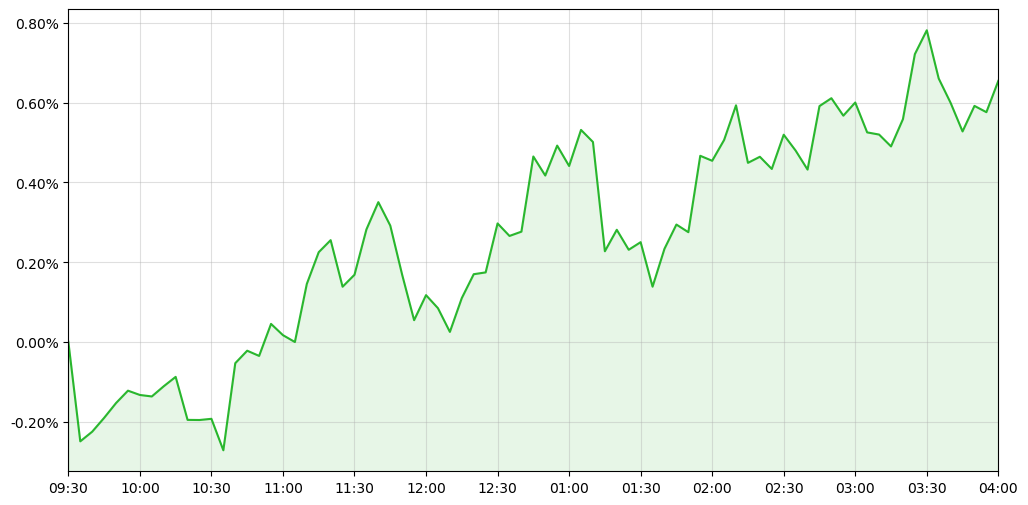

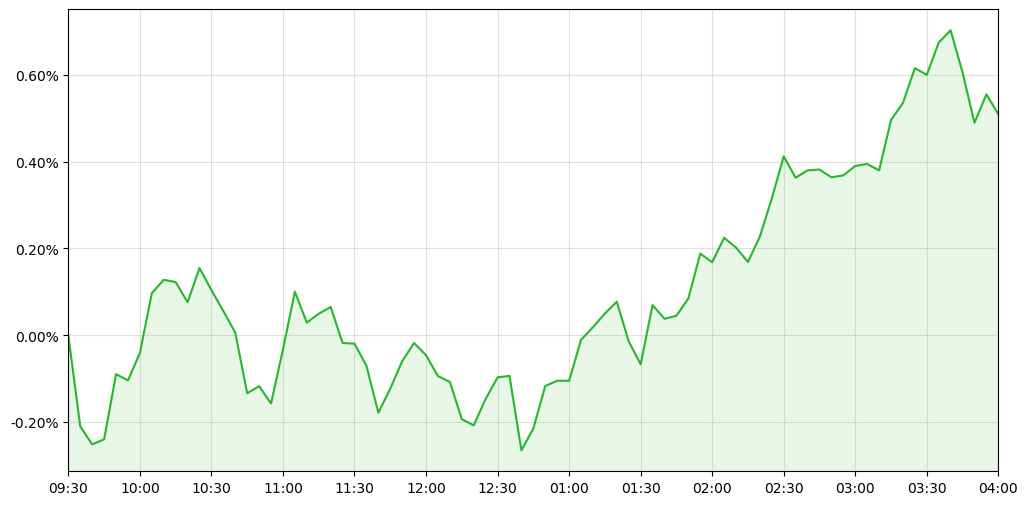

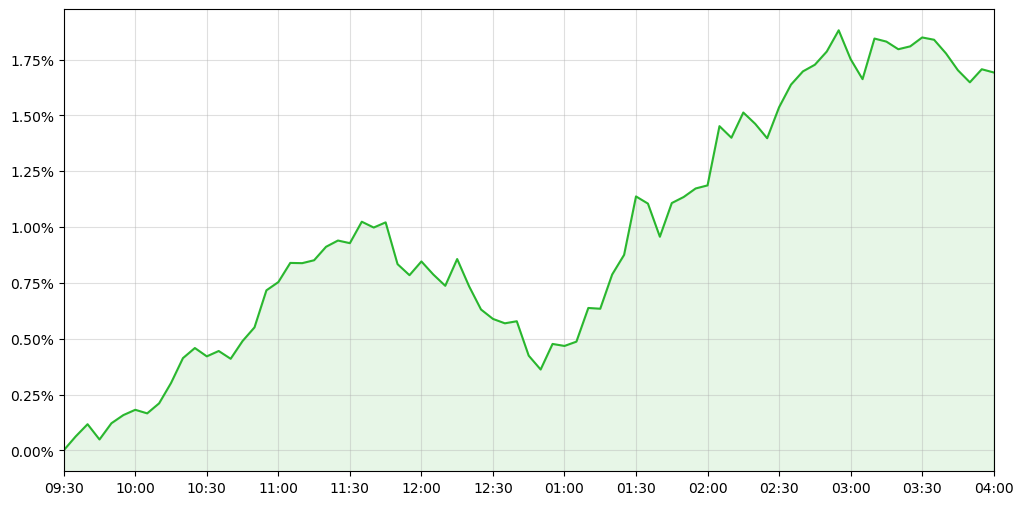

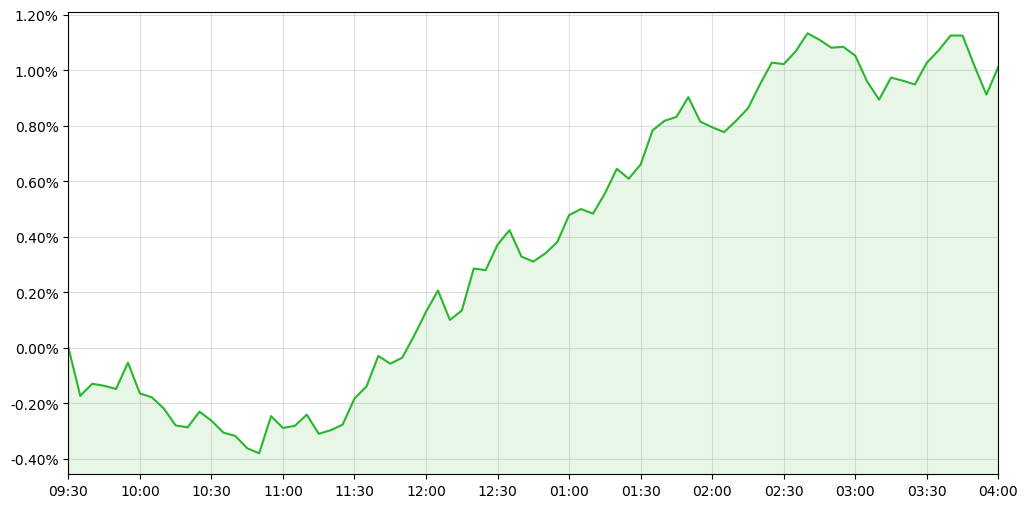

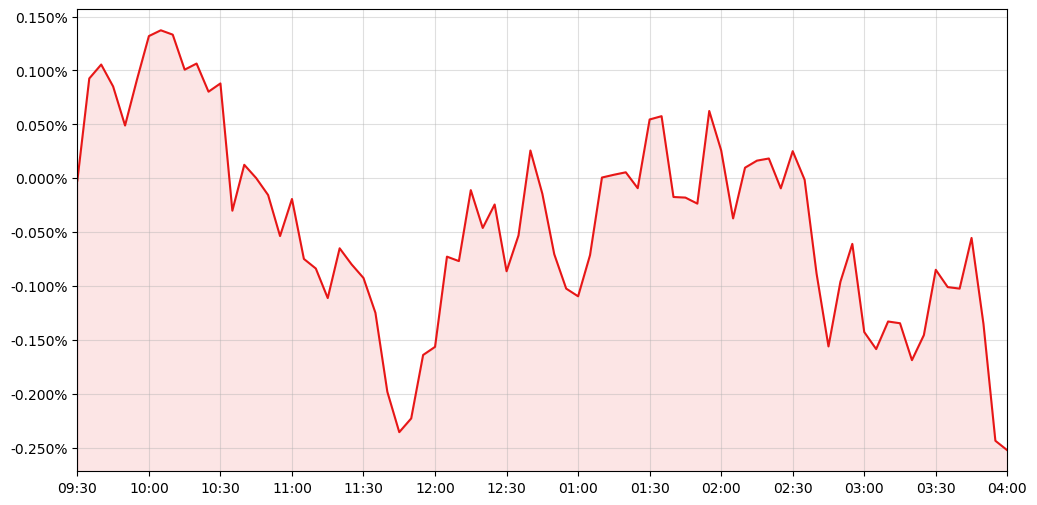

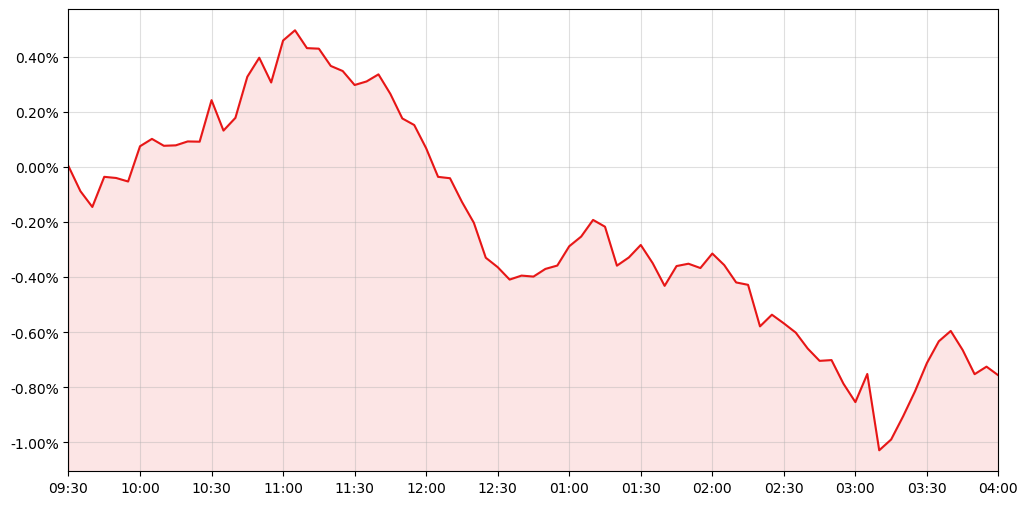

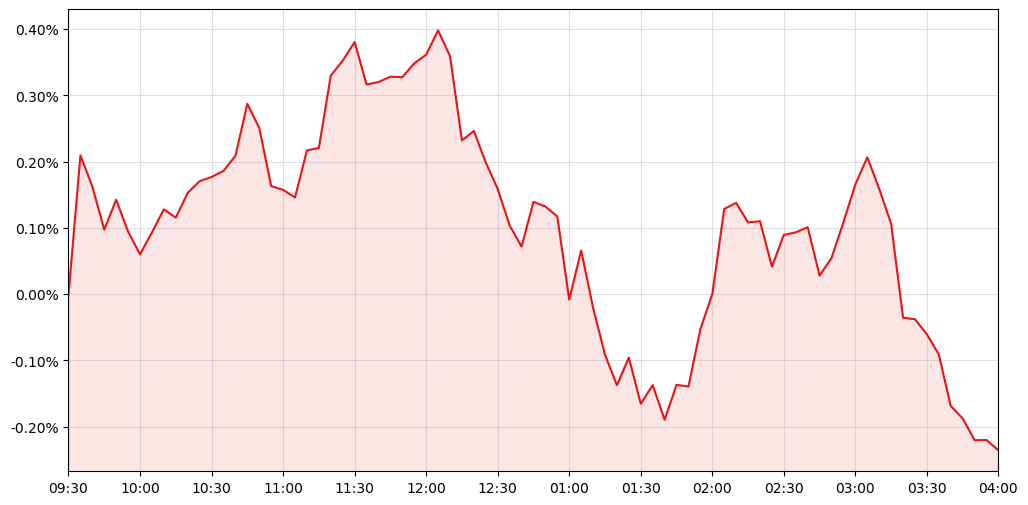

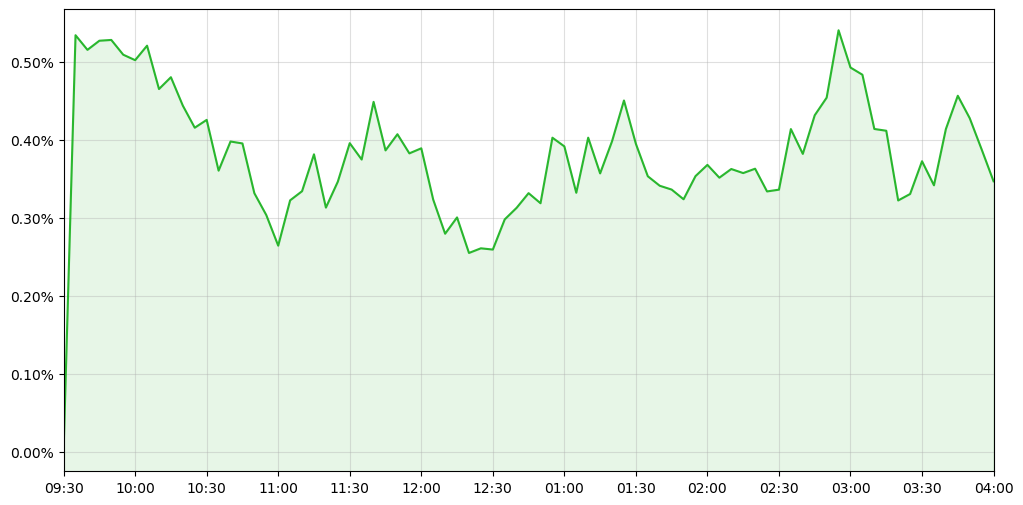

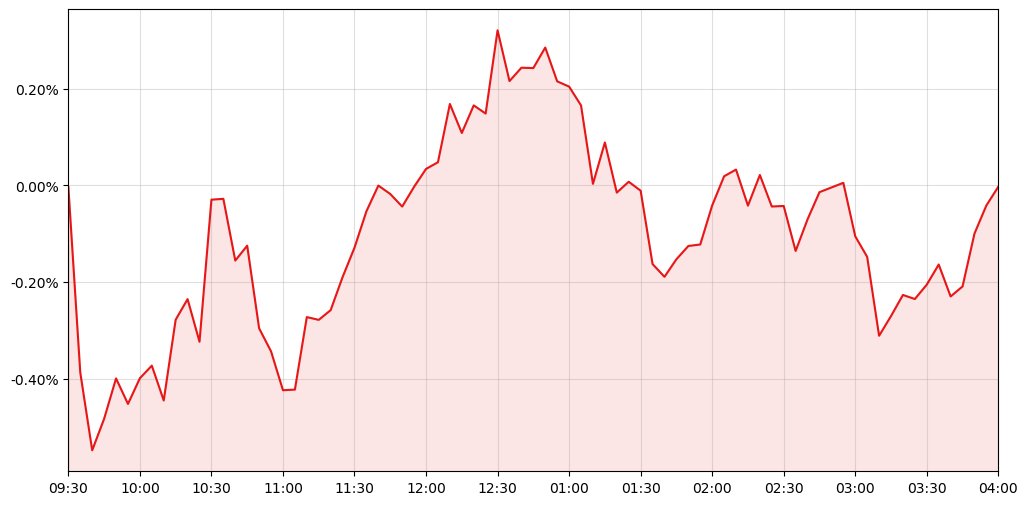

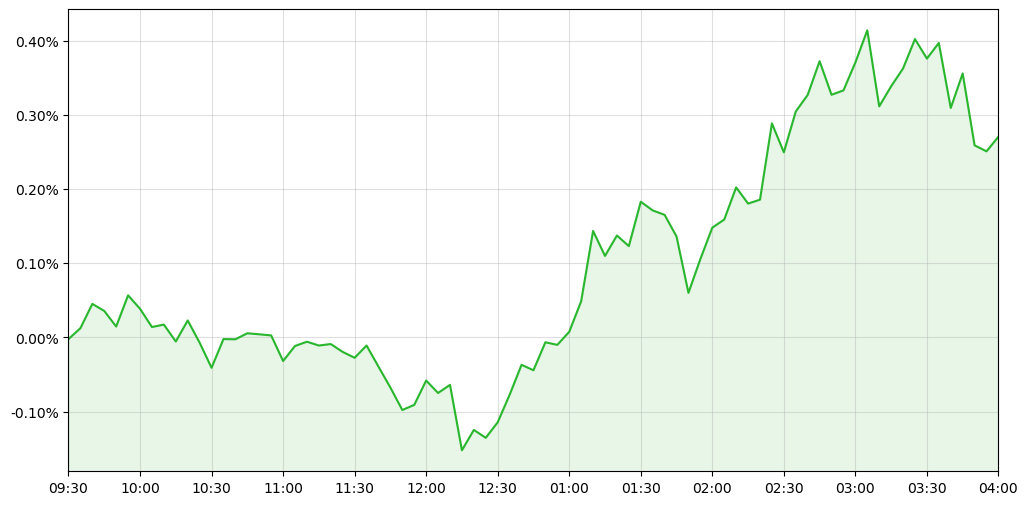

In [6]:
for i in range(10):
    steps = np.random.randn(seconds + 1)
    expected_volatility = 0.006
    shape = 7
    volatility = np.random.gamma(shape=shape, scale=expected_volatility / shape)
    steps *= volatility
    
    prices = np.cumsum(steps) 
    prices /= expected
    
    starting_price = 0.003 * np.random.randn()
    prices[1:] += starting_price

    if prices[-1] < 0:
        color = 'xkcd:red'
    else:
        color = 'xkcd:green'

    show_every = 5 * 60  
    
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(seconds + 1)[::show_every], prices[::show_every], color=color, alpha=0.9)
    plt.xticks(time_ids, times)

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    plt.grid(alpha=0.4)
    plt.xlim(0, seconds + 1)
    lims = plt.ylim()
    plt.ylim(lims)
    plt.fill_between(np.arange(seconds + 1)[::show_every], 
                     np.full(seconds + 1, lims[0])[::show_every], 
                     prices[::show_every], 
                    alpha=0.1, color=color)
#     print(100 * volatility)
    plt.show()
#     print('\n\n\n')

In [7]:
from scipy.special import comb
import scipy.stats as st

In [8]:
def p_value(n_correct, n_trials):
    # the number of selections to choose from is n_trials * 2 and
    # n_trials are chosen
    possible_combs = comb(n_trials * 2, n_trials)

    possible_as_or_greater_combs = 0
    for n in range(n_correct, n_trials + 1):
        possible_as_or_greater_combs += comb(n_trials, n) * comb(n_trials, n_trials - n)

    return possible_as_or_greater_combs / possible_combs

In [9]:
p_value(n_correct=4, n_trials=4)

0.014285714285714285

### Alpha Vantage

In [14]:
# Your key here
key = '0B2RGQVL7RX2DXAA'
ts = TimeSeries(key)

In [15]:
aapl, meta = ts.get_daily(symbol='AAPL')

In [19]:
print(aapl['2019-11-29'])

{'1. open': '266.6000', '2. high': '268.0000', '3. low': '265.9000', '4. close': '267.2500', '5. volume': '11654363'}


In [ ]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


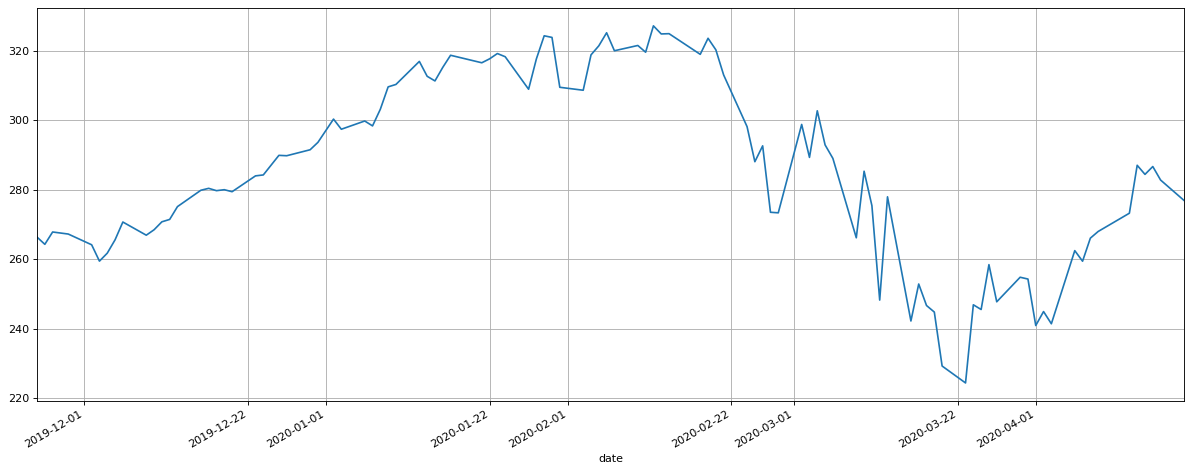

In [23]:
# Chose your output format, or default to JSON (python dict)
ts = TimeSeries(key, output_format='pandas')
ti = TechIndicators(key)

# Get the data, returns a tuple
# aapl_data is a pandas dataframe, aapl_meta_data is a dict
aapl_data, aapl_meta_data = ts.get_daily(symbol='AAPL')
# aapl_sma is a dict, aapl_meta_sma also a dict
aapl_sma, aapl_meta_sma = ti.get_sma(symbol='AAPL')


# Visualization
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
aapl_data['4. close'].plot()
plt.tight_layout()
plt.grid()
plt.show()

In [35]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
print(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2020-04-20 16:00:00   175.00   175.00  175.00    175.00   545027.0
2020-04-20 15:59:00   175.44   175.47  175.25    175.31   263956.0


In [36]:
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2020-04-20 16:00:00,175.000,175.000,175.0000,175.0000,545027.0
2020-04-20 15:59:00,175.440,175.470,175.2500,175.3100,263956.0
2020-04-20 15:58:00,175.420,175.540,175.3600,175.4400,193622.0
2020-04-20 15:57:00,175.440,175.590,175.3627,175.4300,193743.0
2020-04-20 15:56:00,175.290,175.490,175.2000,175.4200,213976.0
...,...,...,...,...,...
2020-04-15 09:35:00,171.350,171.350,170.9758,170.9758,196950.0
2020-04-15 09:34:00,171.300,171.300,171.3000,171.3000,164388.0
2020-04-15 09:33:00,170.780,171.130,170.6000,170.9450,165145.0


In [39]:
ts1 = TimeSeries(key=key, output_format='pandas')
data1, meta_data1 = ts.get_intraday(symbol='^GSPC',interval='5min', outputsize='full')
print(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2020-04-20 16:00:00   175.00   175.00  175.00    175.00   545027.0
2020-04-20 15:59:00   175.44   175.47  175.25    175.31   263956.0


In [40]:
data1

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2020-04-21 13:40:00,2750.4800,2756.1599,2748.6799,2756.0400,19419810.0
2020-04-21 13:35:00,2750.6899,2750.9199,2747.7000,2750.4900,17977681.0
2020-04-21 13:30:00,2749.2300,2750.9299,2747.4399,2750.6399,17175518.0
2020-04-21 13:25:00,2744.1799,2751.6001,2744.0601,2749.6499,20065388.0
2020-04-21 13:20:00,2740.9900,2745.3999,2740.4199,2744.1499,17238969.0
...,...,...,...,...,...
2020-03-31 09:55:00,2598.3401,2601.9600,2592.7600,2595.3301,42380856.0
2020-03-31 09:50:00,2609.1001,2609.1799,2597.8401,2598.4299,45294794.0
2020-03-31 09:45:00,2607.4800,2616.8999,2607.4800,2609.4900,47545650.0


In [1]:
import pandas as pd

In [7]:
pd.read_csv('../data/test.csv')

,a,b
0,1,2
